In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

In [2]:
def read_seismic_cube(file_path):
    """
    :param file_path: Путь к файлу
    :return: возвращает куб в виде списков по Inlines, Xlines и Sampels (координаты x, y, z)
    а также словарю сейсмотрасс, где ключ это координата пересечения Inlines и Xlines, а значение это список значений сейсмотрасс
    """
    with segyio.open(file_path, 'r') as segyfile:
    	x = list(segyfile.ilines)
    	y = list(segyfile.xlines)
    	z = list(segyfile.samples)
    	cube = segyio.tools.cube(segyfile)
    	traces = {f"{x[i]}_{y[j]}": cube[i][j][:] for i in range(len(x)) for j in range(len(y))}
    return x, y, z, traces

In [4]:
def calculate_intervals(input_list, data_dict):
    result_dict = {}
    for key, values in data_dict.items():
        means = []
        variances = []
     	
        for i in range(len(input_list) - 1):
            r1 = input_list[i]
            r2 = input_list[i+1]
            
            # Вычисляем среднее значение на интервале r1, r2
            interval_values = values[r1:r2]
            mean_value = np.mean(interval_values)
            variance_value = np.var(interval_values)
         	
            means.append(mean_value)
            variances.append(variance_value)
     	
        result_dict[key] = [means, variances]
    return result_dict


In [5]:
def find_outliers(data):
 	# Вычисляем первый и третий квартиль
 	Q1 = np.percentile(data, 25)
 	Q3 = np.percentile(data, 75)
 	
 	# Интерквартильный размах
 	IQR = Q3 - Q1
 	
 	# Границы выбросов
 	lower_bound = Q1 - 1.5 * IQR
 	upper_bound = Q3 + 1.5 * IQR
 	
 	# Список индексов выбросов
 	outliers_indices = [i for i, x in enumerate(data) if x < lower_bound or x > upper_bound]
 	
 	return outliers_indices

In [6]:
file_path = 'D:/HV/seismika/datas/Cube_TWT.segy'
ilines, xlines, samples, traces = read_seismic_cube(file_path)

[0, 41, 82, 123]


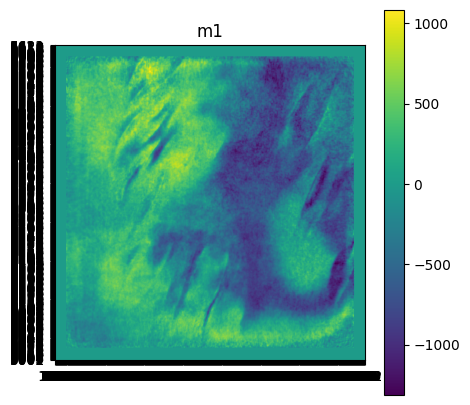

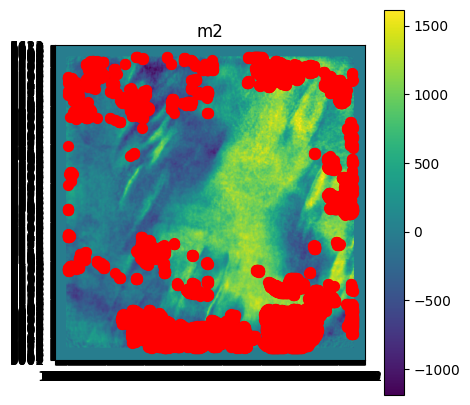

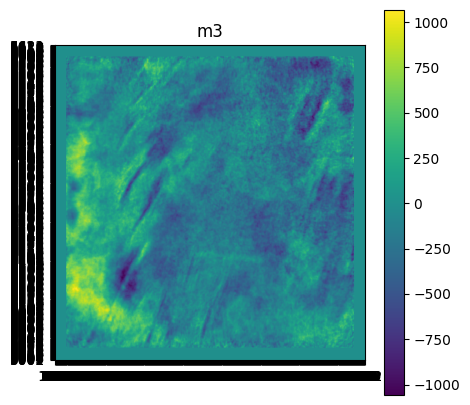

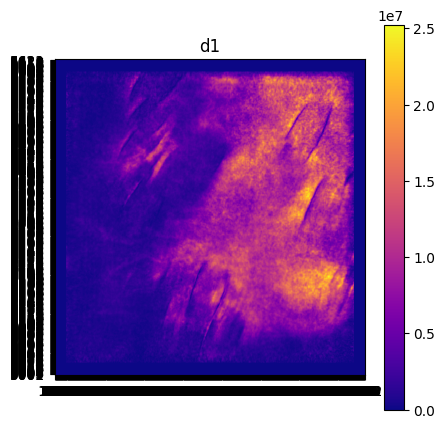

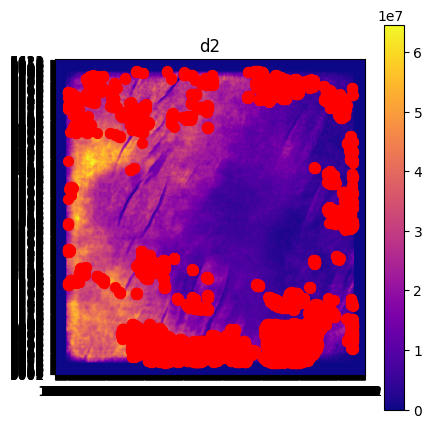

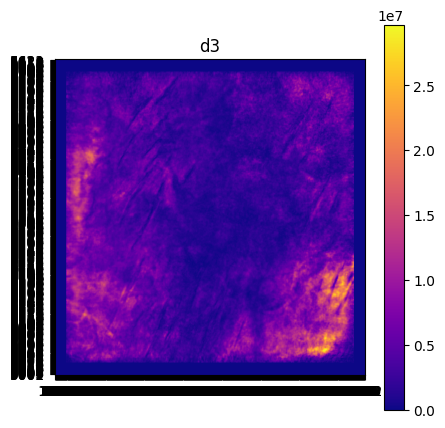

In [12]:
chasti = 3
len_chasti = len(samples)//chasti
intervals = []
for i in range(chasti):
    intervals.append(i*len_chasti)
intervals.append(len(samples))
print(intervals)
ampl_disp = calculate_intervals(intervals, traces)
test_ilines = [[], []]
for k in range(chasti):
    for i in ilines:
        line_amp = []
        line_disp = []
        for j in xlines:
        	line_amp.append(ampl_disp[str(i)+'_'+str(j)][0][k])
        	line_disp.append(ampl_disp[str(i)+'_'+str(j)][1][k])
        test_ilines[0].append(find_outliers(line_amp))
        test_ilines[1].append(find_outliers(line_disp))
coordinates_inlines = []
for n in range(2):
    c = 0
    for i in range(len(test_ilines[n])):
        if 0 <= i < len(ilines):
            c = i
        elif len(ilines) <= i < 2*len(ilines):
            c = i - len(ilines)
        else:
            c = i - 2*len(ilines)
        for j in range(len(test_ilines[n][i])):
            coordinates_inlines.append(str(ilines[c])+'_'+str(xlines[test_ilines[n][i][j]]))

coordinates = []
m1_map = {}
m2_map = {}
m3_map = {}
d1_map = {}
d2_map = {}
d3_map = {}

for coord, values in ampl_disp.items():
    x, y = map(int, coord.split('_'))
    m1_map[(x, y)] = values[0][0]
    m2_map[(x, y)] = values[0][1]
    m3_map[(x, y)] = values[0][2]
    d1_map[(x, y)] = values[1][0]
    d2_map[(x, y)] = values[1][1]
    d3_map[(x, y)] = values[1][2]
    coordinates.append((x, y))

# Определяем размеры сетки
x_coords, y_coords = zip(*coordinates)
x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

# Создаем массивы для heatmaps
def create_heatmap(data_map, x_max, y_max, x_min=1, y_min=1):
    heatmap = np.zeros((x_max - x_min + 1, y_max - y_min + 1))
    for (x, y), value in data_map.items():
        heatmap[x - x_min, y - y_min] = value
    return heatmap

m1_heatmap = create_heatmap(m1_map, x_max, y_max, x_min, y_min)
m2_heatmap = create_heatmap(m2_map, x_max, y_max, x_min, y_min)
m3_heatmap = create_heatmap(m3_map, x_max, y_max, x_min, y_min)
d1_heatmap = create_heatmap(d1_map, x_max, y_max, x_min, y_min)
d2_heatmap = create_heatmap(d2_map, x_max, y_max, x_min, y_min)
d3_heatmap = create_heatmap(d3_map, x_max, y_max, x_min, y_min)

# Функция для добавления красных точек
def add_red_points(ax, highlight_coords, x_min=1, y_min=1):
    for coord in highlight_coords:
        x, y = map(int, coord.split('_'))
        ax.scatter(x, y, color='red', s=50)  # s=50 для диаметра 5

# Построение и сохранение каждой карты отдельно

# m1
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(m1_heatmap, cmap='viridis', interpolation='nearest',
             	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('m1')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
plt.show()

 # m2
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(m2_heatmap, cmap='viridis', interpolation='nearest',
            	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('m2')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
add_red_points(ax, coordinates_inlines, x_min, y_min)
plt.show()

 # m3
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(m3_heatmap, cmap='viridis', interpolation='nearest',
            	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('m3')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
plt.show()

 # d1
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(d1_heatmap, cmap='plasma', interpolation='nearest',
             	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('d1')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
plt.show()

# d2
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(d2_heatmap, cmap='plasma', interpolation='nearest',
            	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('d2')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
add_red_points(ax, coordinates_inlines, x_min, y_min)
plt.show()

# d3
fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.imshow(d3_heatmap, cmap='plasma', interpolation='nearest',
            	extent=[x_min - 0.5, x_max + 0.5, y_min - 0.5, y_max + 0.5])
ax.set_title('d3')
ax.set_xticks(range(x_min, x_max + 1))
ax.set_yticks(range(y_min, y_max + 1))
fig.colorbar(cax, ax=ax)
plt.show()

